# **Exercise 1: Setting up the environment**

In [37]:
!pip install pgmpy

# **Importing Libraries**

In [38]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.inference import BeliefPropagation
from pgmpy.factors.discrete import TabularCPD

# **Exercise 2: building a simple Bayesian Network**

In [39]:
models = BayesianModel([('Weather', 'Traffic' ), ('Traffic', 'Late')])

# **Define Conditional Probability Tables (CPTs):**

In [40]:
# weather cpd
cpd_weather = TabularCPD(variable = 'Weather', variable_card= 2, values= [[0.8], [0.2]])

# traffic cpd given the weather
cpd_traffic = TabularCPD(variable= 'Traffic',
variable_card= 2, values= [[0.9, 0.5], [0.1, 0.5]], # light, sunny , rainy
evidence= ['Weather'], evidence_card= [2])

cpd_late = TabularCPD(variable= 'Late', variable_card= 2,
values= [[0.9, 0.6], [0.1, 0.4]],
evidence= ['Traffic'], evidence_card= [2])

# add cpds to the model

models.add_cpds(cpd_weather, cpd_traffic, cpd_late )

# check if the model is valid
assert models.check_model()

# **Exercise 3: Querying the bayesian Network**

In [41]:
# create an inferance object
inference = VariableElimination(models)

#query the probability of being late given that the wether is Rainy
result = inference.query(variables= ['Late'], evidence= {'Weather': 1})
print(result)

+---------+-------------+
| Late    |   phi(Late) |
+=========+=============+
| Late(0) |      0.7500 |
+---------+-------------+
| Late(1) |      0.2500 |
+---------+-------------+


# **Exercise 4: Parameter Learning**

In [42]:
# create a syntethic dataset
# 0 for sunny, 1 for rainy

data = pd.DataFrame({
    'Weather': np.random.choice([0,1], size = 1000, p=[0.8, 0.2]),
    'Traffic': np.nan,
    'Late': np.nan
})

# fill traffic basesd on Weather
data.loc[data['Weather'] == 0, 'Traffic'] = np.random.choice([0,1], size= data[data['Weather']== 0].shape[0], p= [0.1, 0.9] )

data.loc[data['Weather'] == 1, 'Traffic'] = np.random.choice([0,1], size= data[data['Weather']== 1].shape[0], p= [0.5, 0.5] )

# fill late based on traffic

data['Late'] = np.where (
    data['Traffic']==0,
    np.random.choice([0,1], size= data.shape[0], p= [0.95, 0.05] ),
    np.random.choice([0,1], size= data.shape[0], p= [0.4, 0.6] )

)

# **Estimate the Parammeters**

In [45]:
from pgmpy.estimators import MaximumLikelihoodEstimator

# CREATE A BAYESIAN MODEL
model= BayesianModel([('Weather', 'Traffic'), ('Traffic', 'Late')]) # Add a comma between the tuples

# fit the model to the data using maximum likelihood estimation
model.fit(data, estimator= MaximumLikelihoodEstimator)

for cpd in model.get_cpds():
  print(cpd)

+------------+-------+
| Weather(0) | 0.795 |
+------------+-------+
| Weather(1) | 0.205 |
+------------+-------+
+--------------+--------------------+---------------------+
| Weather      | Weather(0)         | Weather(1)          |
+--------------+--------------------+---------------------+
| Traffic(0.0) | 0.1069182389937107 | 0.5219512195121951  |
+--------------+--------------------+---------------------+
| Traffic(1.0) | 0.8930817610062893 | 0.47804878048780486 |
+--------------+--------------------+---------------------+
+---------+---------------------+---------------------+
| Traffic | Traffic(0.0)        | Traffic(1.0)        |
+---------+---------------------+---------------------+
| Late(0) | 0.9114583333333334  | 0.39603960396039606 |
+---------+---------------------+---------------------+
| Late(1) | 0.08854166666666667 | 0.6039603960396039  |
+---------+---------------------+---------------------+


# **Visualizing the Bayesian Network**

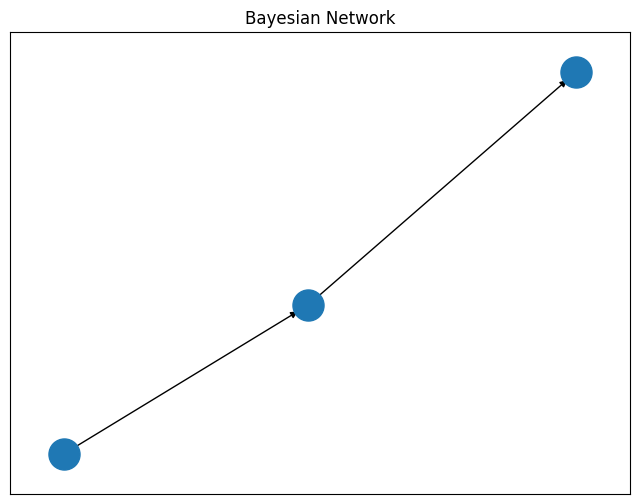

In [52]:
!pip install networkx
import matplotlib.pyplot as plt
import networkx as nx  # Changed 'network' to 'networkx'

nx_graph = nx.DiGraph(model.edges())
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(nx_graph)
nx.draw_networkx_nodes(nx_graph, pos, node_size=500)
nx.draw_networkx_edges(nx_graph, pos, edgelist=model.edges(),  arrows=True)
plt.title('Bayesian Network')
plt.show()